In [ ]:
import pandas as pd
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, AutoDateFormatter
from statsmodels.tsa.arima.model import ARIMA
from sklearn.ensemble import RandomForestRegressor

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

from scipy.stats import skew, kurtosis

from scipy.stats import pointbiserialr
import random
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import warnings
import os
import sys

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import accuracy_score
import math

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

from sklearn.naive_bayes import GaussianNB

import yfinance as yf
import pandas_datareader as pdr

from scipy.stats import pointbiserialr

import requests

from statsmodels.distributions.empirical_distribution import ECDF

Read in Fama-French 3 Factor data to use for CAPM estimates

In [ ]:
ff_factors = pd.read_csv("/content/FF_Factors_Weekly.csv")
ff_factors['Date'] = pd.to_datetime([str(item)[:4] + '-' + str(item)[4:6] + '-' + str(item)[6:] for item in list(ff_factors['Date'])])
ff_factors['Date'] = ff_factors['Date'] - pd.DateOffset(days=4)
ff_factors['Mkt'] = ff_factors['Mkt-RF'] + ff_factors['RF']

Fetch Tickers for all SP500 Companies

In [ ]:


# Fetch data from the S&P 500 index
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(url)
data = pd.read_html(response.text)

# Extract the table containing S&P 500 data
sp500_data = data[0]

# # Sort the companies by market capitalization
sp500_data_sorted = sp500_data.sort_values(by='Founded', ascending=True)

# # Select the top 200 companies
top_200_companies = sp500_data_sorted

top_200_symbols = list(top_200_companies['Symbol'])

top_200_symbols.remove('GEV')
top_200_symbols.remove('CTRA')
top_200_symbols.remove('DXCM')

In [ ]:
class SuppressOutput:
    def __enter__(self):
        self.stdout = sys.stdout
        self.stderr = sys.stderr
        self.devnull = open(os.devnull, 'w')
        sys.stdout = self.devnull
        sys.stderr = self.devnull

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self.stdout
        sys.stderr = self.stderr

Pull down data for all SP500 companies

In [ ]:
def filter_data(ticker_list, start, end):

    data_list = []

    for ticker in ticker_list:
        with SuppressOutput():
            data = yf.download(ticker, start=start, end=end)
        data_list.append(data)

    return dict(zip(ticker_list, data_list))

In [ ]:
train_start_date = '2018-01-01'
train_end_date = '2020-01-01'

test_start_date = '2020-01-01'
test_end_date = '2024-06-03'

train_set = filter_data(top_200_symbols, train_start_date, train_end_date)
test_set = filter_data(top_200_symbols, test_start_date, test_end_date)

ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFTzMissingError('$%ticker%: possibly delisted; No timezone found')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: YFPricesMissingError('$%ticker%: possibly delisted; No price data found  (1d 2018-01-01 -> 2020-01-01)')
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['GEHC']: YFChartError("%ticker%: Data doesn't exist for startDate = 1514782800, endDate = 1577854800")
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CEG']: YFChartError("%ticker%: Data doesn't exist for startDate = 1514782800, endDate = 1577854800")
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['ABNB']: YFChartError("%ticker%: Data doesn't exist for startDate = 1514782800, endDate = 1577854800")
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['OTIS']: YFChartError("%ticker%: Data doesn't exist for startDate = 1514782800, endDate = 1577854800")
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['CARR']: YFChartError("%ticker%: Data do

Build dataframe of return signals including whether trade hits the return threshold over 10-day time period (signal = 1) or if option should be exercised on expiry (last_price). The goal is to identify 5% returns in the underlying over a 10 day period and take a position in those assets with an at-the-money 10DTE call option. The goal of 5% is estimated from the conclusion that 10 DTE at-the-money call options on average are 2.3% of the asset price and with a buffer we estimate the cost to be 2.5% (it would be preferred to have the actual options price available at each trade but the data was not available to me). The reasoning for choosing the 5% estimate is given below:

Consider the target return on the asset to be *R* and the option price to be *OP*, and the probability of predicting *R* correctly to be *p*. Then we want the expected value of a trade to be positive which is given by:

E*(profit)* = *p(R - OP) + (1-p)(-OP) > 0* let *R = 2(OP)* then the expected value simplifies to:

E*(profit)* = *p(2(OP) - OP) + (1-p)(-OP) > 0*

E*(profit)* = *2p + 1 > 0 -->* ***p* > .5**

Thus, if we have a 2.5% option cost then if we predict a 5% gain in the underlying with greater than 50% accuracy, we should expect to make money on each trade and making as money of such trades as possible should yield an expected profit.


In [ ]:
def build_return_signal(group):
  group['signal'] = 0
  group['last_day'] = 0
  group['last_price'] = 0
  for i in range(len(group)):
    open_price = group['Open'].iloc[i]
    future_highs = group['High'][i: min(i+10, len(group))]

    if (future_highs >= open_price * 1.06).any():
        group['signal'][i] = 1
    group['last_price'][i] = group['Close'][min(i+9, len(group) - 1)] / open_price - 1

  return group

Trend indicator of OLS coefficient in rolling window of asset prices (not used)

In [ ]:
def calculate_ols_coefficient(window_data):
    X = sm.add_constant(range(len(window_data)))
    y = window_data

    model = sm.OLS(y, X).fit()

    coefficient = model.params[1]

    return coefficient

In [ ]:
def build_ols(group):
  group['OLS'] = (group['Close'].rolling(window=30).apply(calculate_ols_coefficient, raw=True))
  group['OLS'] = group['OLS'].shift(1)

  return group

Trend indicator of rate of change in short/long term moving averages over 10-day period (not used)

In [ ]:
def build_ma_factors(group):
  group['sma'] = group['Close'].ewm(span=25, adjust=False).mean()
  group['lma'] = group['Close'].ewm(span=100, adjust=False).mean()

  # group['sma_change'] = np.abs(group['sma'].rolling(window=25).apply(calculate_ols_coefficient, raw=True))
  # group['lma_change'] = np.abs(group['lma'].rolling(window=25).apply(calculate_ols_coefficient, raw=True))

  # Calculate the rate of change in the 5-day moving average
  # window_size = 5  # Size of the rolling window
  group['sma_change'] = np.abs(group['sma'].pct_change(10))
  group['lma_change'] = np.abs(group['lma'].pct_change(10))

  group['sma_change'] = group['sma_change'].shift(1)
  group['lma_change'] = group['lma_change'].shift(1)

  return group


Trend indicator (MAPD = Moving Average Percentage difference) defined by percentage difference in short and long term moving averages normalized by long term moving average (to make indicator normalized across assets and viable input for classification). Data is shifted by 1 row to ensure that models only train and predict on past data. (USED)

In [ ]:
def build_macd(data):
    short_window=12
    long_window=26

    short_ema = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    ppo = ((short_ema - long_ema) / long_ema) * 100

    data['MAPD'] = ppo
    data['MAPD'] = data['MAPD'].shift(1)


    return data

Average True Range volatility indicator normalized by closing price (to make indicator normalized across assets and viable input for classification). Data is shifted by 1 row to ensure that models only train and predict on past data. (USED)

In [ ]:
def build_atr(data):
    window=14
    def normalize(series):
        return (series - series.min()) / (series.max() - series.min())

    high_low = data['High'] - data['Low']
    high_close_prev = abs(data['High'] - data['Close'].shift(1))
    low_close_prev = abs(data['Low'] - data['Close'].shift(1))

    true_range = pd.concat([high_low, high_close_prev, low_close_prev], axis=1).max(axis=1)

    atr = true_range.rolling(window=window, min_periods=1).mean()

    normalized_atr_percentage = normalize(atr / data['Close']) * 100

    data['ATR'] = normalized_atr_percentage

    data['ATR'] = data['ATR'].ewm(alpha= .2, min_periods=window).mean()

    data['ATR'] = data['ATR'].shift(1)

    return data

Trend indicator of average directional index, already normalized across assets (not used)

In [ ]:
def build_adx(data):
    window=15
    close_diff = np.abs(data['Close'].diff())
    high_diff = data['High'].diff()
    low_diff = data['Low'].diff()
    tr = pd.concat([close_diff, high_diff, low_diff], axis=1).max(axis=1)
    atr = tr.rolling(window=window).mean()
    up_move = data['High'].diff()
    down_move = -data['Low'].diff()
    positive_dm = pd.Series(np.where((up_move > down_move) & (up_move > 0), up_move, 0))
    negative_dm = pd.Series(np.where((down_move > up_move) & (down_move > 0), down_move, 0))
    ema_positive_dm = positive_dm.ewm(span=window, min_periods=1).mean()
    ema_negative_dm = negative_dm.ewm(span=window, min_periods=1).mean()
    di_plus = 100 * (ema_positive_dm / atr)
    di_minus = 100 * (ema_negative_dm / atr)
    dx = 100 * np.abs((di_plus - di_minus) / (di_plus + di_minus))
    adx = dx.rolling(window=window).mean()

    data['ADX'] = adx
    return data

Stochastic Oscillator trend indicator (not used)

In [ ]:
def build_stoch_oscillator(data):
  window = 15
  smooth_window = 3
  low_min = data['Low'].rolling(window=window).min()
  high_max = data['High'].rolling(window=window).max()
  k_percent = 100 * ((data['Close'] - low_min) / (high_max - low_min))
  d_percent = k_percent.rolling(window=smooth_window).mean()
  stochastic_signal = k_percent - d_percent
  data['STOCH'] = stochastic_signal

  data['STOCH'] = data['STOCH'].shift(1)

  return data

Generates dataframe of all possible trades along with all possible indicators and whether the trade would have hit the return threshold or not. Basically builds the main dataframe with all the data needed to backtest.

In [ ]:
def create_train_data(train_set):
  for key in train_set.keys():
    train_set[key]['Ticker'] = key

  train_df = pd.concat(train_set.values())
  train_df2 = train_df.groupby('Ticker').apply(build_return_signal)
  train_df2 = train_df2.reset_index(level = 'Ticker', drop = True)
  train_df2 = train_df2.reset_index()

  train_df3 = train_df2.groupby('Ticker').apply(build_macd)
  train_df3 = train_df3.reset_index(drop = True)

  train_df3 = train_df3.groupby('Ticker').apply(build_atr)
  train_df3 = train_df3.reset_index(drop = True)

  monday_df = train_df3[train_df3['Date'].dt.dayofweek == 0]

  monday_df_clean = monday_df.dropna()

  return monday_df_clean

Plots trades based on various signals to visualize possible trends

In [ ]:
def create_scatter(data):
  data_loss = data[data['signal'] == 0]
  data_win = data[data['signal'] == 1]

  plt.figure(figsize = (12, 7))
  plt.scatter(data_win['ATR'], (data_win['MAPD']), color = 'blue')
  plt.scatter(data_loss['ATR'], (data_loss['MAPD']), color = 'red')
  plt.xlabel('ATR')
  plt.ylabel('MAPD')
  plt.show()

Model trained to predict movements with input space of the MAPD and ATR indicators and output of 1 if the data is likely to see a 5% gain in the underlying over the next 10 days and 0 if not. A bagging decision tree classifier was used as the model of choice due to decision trees being more able to capture non-linearities (regions of good trades) compared to other models (e.g. SVMs, Neural Nets, and Logistic Regression). Furthermore the bootstrapping of the bagging classifier along with the ability to specify constraints on the base classifier to have lower depths and larger leafs allows for better generalization and less risk of overfitting.

In [ ]:
def train_model(train_data):

  base_classifier = DecisionTreeClassifier(
    max_depth=5,
    min_samples_leaf=5,
    random_state=37
  )

  modeler = BaggingClassifier(
      base_estimator=base_classifier,
      n_estimators=100,
      bootstrap=True,
      random_state=37
  )

  modeler.fit(train_data[:,:-1], train_data[:, -1])

  return modeler

Create training and test dataframes

In [ ]:
train_df = create_train_data(train_set)

In [ ]:
test_df = create_train_data(test_set)

Testing indicators via biserial correlations to the return threshold signal. Correlations of >.1 may seem insignificant but when visualized they show that on the edges of the distributions of data that concentrations of successful trades exist and can be identified with a classification  model. The ATR and MAPD were also selected together because they have a low correlation with one another and thus provide different information that should support stronger classifier learning. The lack of correlation also suggests that although we use the percentage of the MAPD, that it might still provide information on trends rather than volatility as it is minimally correlated with the ATR volatility indicator.

In [ ]:
def test_indicators(train_df):
  print(pointbiserialr(train_df['ATR'], train_df['signal']))
  print(pointbiserialr((train_df['MAPD']), train_df['signal']))
  print(pointbiserialr((train_df[train_df['MAPD'] < 0]['MAPD']), train_df[train_df['MAPD'] < 0]['signal']))

In [ ]:
test_indicators(train_df)

SignificanceResult(statistic=0.1768510189853313, pvalue=1.0309865e-317)
SignificanceResult(statistic=-0.16954428299286678, pvalue=8.391850599174997e-292)
SignificanceResult(statistic=-0.19394609993610715, pvalue=1.7277597638800697e-161)


In [ ]:
test_indicators(test_df)

SignificanceResult(statistic=0.26485537937422243, pvalue=0.0)
SignificanceResult(statistic=-0.14327483043272757, pvalue=0.0)
SignificanceResult(statistic=-0.24262627611564663, pvalue=0.0)


In [ ]:
print(np.corrcoef(train_df['ATR'], abs(train_df['MAPD'])))

[[1.         0.20197719]
 [0.20197719 1.        ]]


The plot below shows that on the edge of the scatter/ distribution of data that concentrations of successful trades do exist within the training set and can possibly be learned

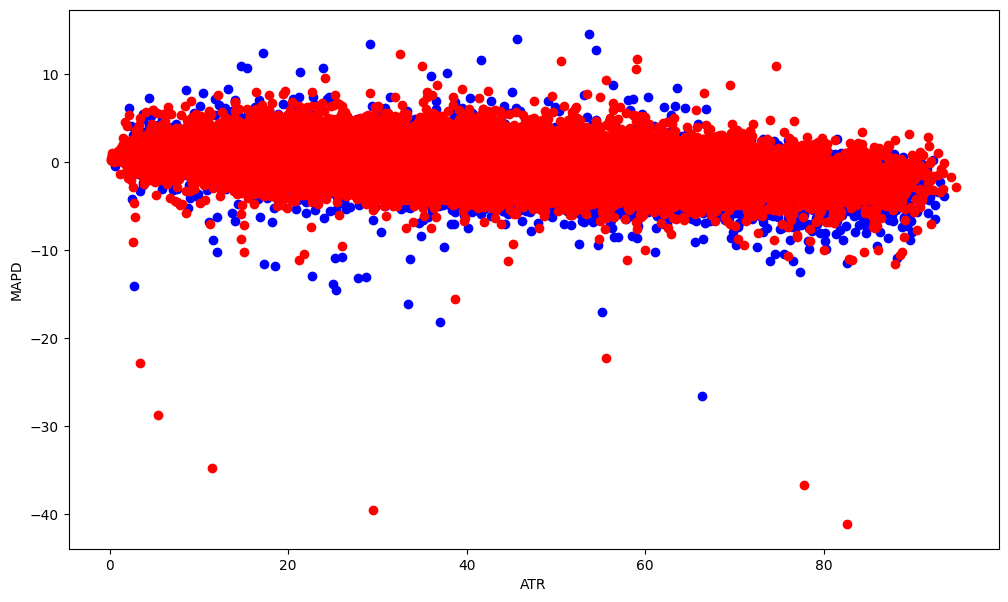

In [ ]:
create_scatter(train_df)

Code for getting portfolio returns. Since positions are taken weekly but for a 2 week time period, we only have access to capital liquidated within 1 week and capital not allocated to the previous week. On average this comes to around 60% of capital available each week.

In [ ]:
def get_portfolio_returns(group):
  total_return = group['return'].sum()
  group['total_return'] = 1 / len(group) * total_return / 2
  return group

Main function for running predictions and testing returns. Trains the classifier on the training set and then evaluates on the test set and builds a time series of returns. The train and test data are immediately trimmed for some thresholds of the MAPD

In [ ]:
def get_return_df(train_df, test_df):
  plot_df = train_df[(train_df['ATR'] > 40) | (train_df["MAPD"] < -5)]
  train_array = np.array(plot_df[['ATR', 'MAPD', 'signal']])

  plot_test_df = test_df[(test_df["MAPD"] < -5)]
  eval_array = np.array(plot_test_df[['ATR', 'MAPD', 'signal']])

  model = train_model(train_array)

  predictions = model.predict_proba(eval_array[:,:-1])
  predictions = list(predictions)

  predictions = [1 if item[1] > .55 else 0 for item in predictions]

  results_df = plot_test_df.copy()

  results_df['prediction'] = predictions

  results_df = results_df[results_df['prediction'] == 1]

  results_df['return'] = ''

  # Calculating returns for each week

  results_df.loc[results_df['prediction'] == results_df['signal'], 'return'] = results_df.loc[results_df['prediction'] == results_df['signal'], 'last_price'] - .03
  results_df.loc[results_df['prediction'] != results_df['signal'], 'return'] = results_df.loc[results_df['prediction'] != results_df['signal'], 'last_price'] - .03
  results_df['return'] = [max(-.03, item) for item in list(results_df['return'])]


  results_df = results_df.sort_values(by = 'Date')

  # print(results_df.tail(20))

  print(len(list(results_df['signal'])))
  print(sum(list(results_df['signal'])))

  results_df = results_df.groupby('Date').apply(get_portfolio_returns)
  results_df = results_df.reset_index(drop = True)

  return_dictionary = results_df[['Date', 'total_return']].to_dict(orient='list')
  linked_dict = {key: value for key, value in zip(return_dictionary['Date'], return_dictionary['total_return'])}

  # Merging returns data with Fama-French 3 factor model data

  ff_week_factors = ff_factors[ff_factors['Date'] >= list(results_df['Date'])[0]]
  # ff_week_factors = ff_factors[ff_factors['Date'] >= '2021-07-01']
  returns_df = pd.DataFrame(list(linked_dict.items()), columns=['Date', 'Strategy Returns'])
  strategy_df = pd.merge(ff_week_factors, returns_df, on='Date', how='left')
  strategy_df.fillna(0, inplace = True)
  strategy_df['Strat Model Returns'] = [item * 100 for item in list(strategy_df['Strategy Returns'])]
  strategy_df['Strat Model Returns'] = strategy_df['Strat Model Returns'] - strategy_df['RF']

  return strategy_df

Running the main returns function to produce all the output data relevant for analysis (test returns, test signals, Fama-French 3 factor data)

In [ ]:
strategy_df = get_return_df(train_df, test_df)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


2412
1797


Plot of strategy returns vs. market (averaging ~22% returns per year)

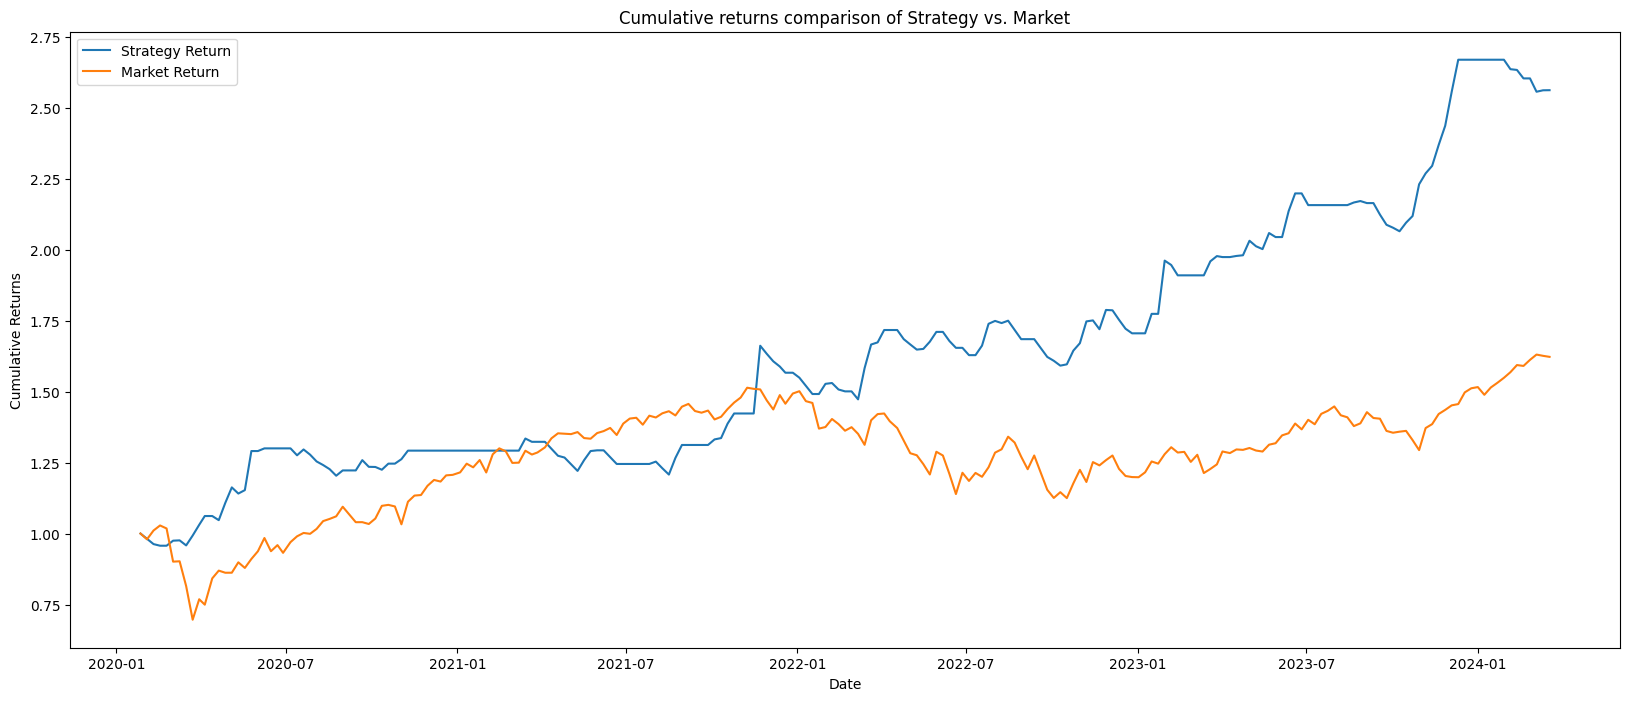

In [ ]:
returns_list = [1 + item for item in list(strategy_df['Strategy Returns'])]
market_returns = [1 + item / 100 for item in list(strategy_df['Mkt'])]
plt.figure(figsize = (20, 8))
plt.plot(strategy_df['Date'], [np.prod(returns_list[0:i]) for i in range(len(returns_list))], label = "Strategy Return")
plt.plot(strategy_df['Date'], [np.prod(market_returns[0:i]) for i in range(len(market_returns))], label = 'Market Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative returns comparison of Strategy vs. Market')
plt.legend()

Functions for estimating loadings of strategy returns onto CAPM and Fama-French 3 factor model

In [ ]:
def estim_CAPM(data_unique_dates):

  model1 = sm.OLS(data_unique_dates['Strat Model Returns'], sm.add_constant(data_unique_dates['Mkt-RF'])).fit()
  alpha, beta = model1.params
  print("CAPM ESTIMATES")
  print(model1.summary())
  # print(f'alpha: {model1.params["const"]}')
  conf_int = model1.conf_int(alpha=0.05)  # Default is 95% confidence interval
  alpha_conf_int = conf_int.loc["const"]  # Confidence interval for the alpha

  # Print the results including the 95th percentile bounds for alpha
  # print("FF5 + MOMENTUM ESTIMATES")
  print(f'alpha: {round(alpha, 3)}')
  print(f'Alpha 95% Confidence Interval: {round(alpha_conf_int[0], 3)} to {round(alpha_conf_int[1], 3)}')

def estim_FF3(data_unique_dates):
  model1=sm.OLS(data_unique_dates['Strat Model Returns'], sm.add_constant(data_unique_dates[['Mkt-RF', 'SMB', 'HML']])).fit()
  alpha, beta_1, beta_2, beta_3 = model1.params
  print("FF3 ESTIMATES")
  print(model1.summary())
  # print(f'alpha: {model1.params["const"]}')

  conf_int = model1.conf_int(alpha=0.05)  # Default is 95% confidence interval
  alpha_conf_int = conf_int.loc["const"]  # Confidence interval for the alpha

  # Print the results including the 95th percentile bounds for alpha
  # print("FF5 + MOMENTUM ESTIMATES")
  print(f'alpha: {round(alpha, 3)}')
  print(f'Alpha 95% Confidence Interval: {round(alpha_conf_int[0], 3)} to {round(alpha_conf_int[1], 3)}')


def get_annual_sharpe_ratio(returns):
  weekly_returns = returns['Strategy Returns'] - returns['RF'] / 100
  average_weekly_return = weekly_returns.mean()

  std_weekly_return = weekly_returns.std()

  average_annual_return = average_weekly_return * 52

  std_annual_return = std_weekly_return * np.sqrt(52)

  risk_free_rate = 0.02

  sharpe_ratio = (average_annual_return - risk_free_rate) / std_annual_return

  print("Annualized Sharpe ratio: {:.3f}".format(sharpe_ratio))

Distribution of trades taken during test set

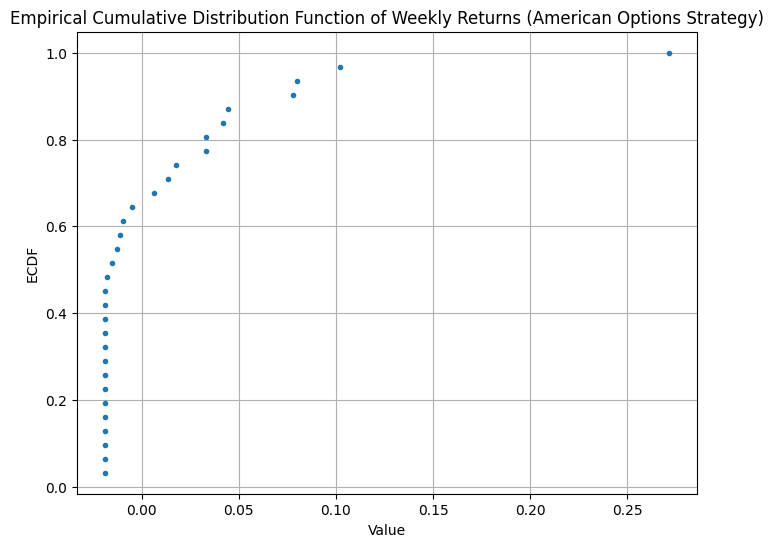

In [ ]:
returns_dist = [item for item in list(strategy_df['Strategy Returns']) if item != 0]

ecdf = ECDF(returns_dist)

plt.figure(figsize=(8, 6))
plt.plot(ecdf.x, ecdf.y, marker='.', linestyle='none')
plt.xlabel('Value')
plt.ylabel('ECDF')
plt.title('Empirical Cumulative Distribution Function of Weekly Returns (American Options Strategy)')
plt.grid(True)
plt.show()

Results from CAPM and FF-3 Model estimates (producing roughly .35% alpha weekly which is ~18% annually) with ~.1 market beta.

In [ ]:
estim_CAPM(strategy_df)

CAPM ESTIMATES
                             OLS Regression Results                            
Dep. Variable:     Strat Model Returns   R-squared:                       0.002
Model:                             OLS   Adj. R-squared:                 -0.003
Method:                  Least Squares   F-statistic:                    0.3954
Date:                 Thu, 06 Jun 2024   Prob (F-statistic):              0.530
Time:                         02:26:25   Log-Likelihood:                -478.80
No. Observations:                  215   AIC:                             961.6
Df Residuals:                      213   BIC:                             968.3
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1488      

In [ ]:
estim_FF3(strategy_df)

FF3 ESTIMATES
                             OLS Regression Results                            
Dep. Variable:     Strat Model Returns   R-squared:                       0.018
Model:                             OLS   Adj. R-squared:                  0.004
Method:                  Least Squares   F-statistic:                     1.259
Date:                 Thu, 06 Jun 2024   Prob (F-statistic):              0.289
Time:                         02:26:25   Log-Likelihood:                -477.09
No. Observations:                  215   AIC:                             962.2
Df Residuals:                      211   BIC:                             975.7
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1569      0

In [ ]:
get_annual_sharpe_ratio(strategy_df)

Annualized Sharpe ratio: 0.329
